# Testes utilizando modelos de grafos

## Importando as bibliotecas

In [1]:
import seaborn as sns; sns.set_theme()
import GeosocialAlgorithms as ga
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import json
import utm
import csv

from sklearn.metrics.cluster import adjusted_mutual_info_score as ami
from matplotlib.colors import LogNorm
from tqdm import tqdm as tqdmBasic

In [2]:
# Definindo número de vértices do grafo
NUMBER_OF_VERTICES = 10000

# Latitudes e longitudes máximas e mínimas
LAT_MIN = 36.9609718322753338
LAT_MAX = 42.1543159484863281
LON_MIN = -9.5470819473266033
LON_MAX = -6.1891422271728516

## Carregando os métodos

### Métodos gerais

In [3]:
def calculate_distance_geographic(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the distance between two points in the geographic space.
    
    Args:
        lat1 (float): Latitude of the first point.
        lon1 (float): Longitude of the first point.
        lat2 (float): Latitude of the second point.
        lon2 (float): Longitude of the second point.
        
    Returns:
        float: The distance between the two points.
        
    Example:
        >>> calculate_distance_geographic(37.7749, -122.4194, 34.0522, -118.2437)
        559.23
    """
    x1, y1, _, _ = utm.from_latlon(lat1, lon1)
    x2, y2, _, _ = utm.from_latlon(lat2, lon2)

    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [4]:
def calculate_distance(xP1: float, yP1: float, xP2: float, yP2: float) -> float:
    """
    Calculate the distance between two points in the Euclidean space.
    
    Args:
        xP1 (float): X-coordinate of the first point.
        yP1 (float): Y-coordinate of the first point.
        xP2 (float): X-coordinate of the second point.
        yP2 (float): Y-coordinate of the second point.
        
    Returns:
        float: The distance between the two points.
        
    Example:
        >>> calculate_distance(0, 0, 3, 4)
        5.0
    """
    P1 = [xP1, yP1]
    P2 = [xP2, yP2]
    
    return math.dist(P1, P2)

In [5]:
def generate_colors(n: int) -> np.ndarray:
    """
    Generate a list of colors for plotting.
    
    Args:
        n (int): Number of colors to generate.
        
    Returns:
        np.ndarray: A list of colors.
        
    Example:
        >>> generate_colors(5)
        array([[1.        , 0.        , 0.        , 1.        ],
               [1.        , 0.5       , 0.        , 1.        ],
               [1.        , 1.        , 0.        , 1.        ],
               [0.5       , 1.        , 0.        , 1.        ],
               [0.        , 1.        , 0.        , 1.        ]])
    """
    cmap = plt.colormaps['hsv']
    colors = cmap(np.linspace(0, 1, n+1))
    return colors

In [6]:
def convert_geo_to_utm(graph: nx.graph, column_lat: str = 'median_lat', column_lon: str = 'median_lon') -> nx.graph:
    """
    Convert the geographic coordinates of the nodes in the graph to UTM coordinates.

    Args:
        graph (nx.graph): A graph object.
        column_lat (str, optional): Column name of the latitude component. Defaults to 'median_lat'.
        column_lon (str, optional): Column name of the longitude component. Defaults to 'median_lon'.

    Returns:
        nx.graph: A graph object with UTM coordinates.
        
    Example:
        >>> G = nx.Graph()
        >>> G.add_node(1, median_lat=37.7749, median_lon=-122.4194)
        >>> G.add_node(2, median_lat=34.0522, median_lon=-118.2437)
        >>> convert_geo_to_utm(G)
        >>> print(G.nodes[1]['median_X'], G.nodes[1]['median_Y'])
        551730.0 4182689.0                
    """
    for node in graph.nodes():
        latitute = float(graph.nodes[node][column_lat])
        longitude = float(graph.nodes[node][column_lon])
        
        easting, northing, _, _ = utm.from_latlon(latitute, longitude)
        graph.nodes[node]['median_X'] = easting
        graph.nodes[node]['median_Y'] = northing
        
    return graph

### Métodos de cálculo com a rede

In [7]:
def show_graph_metrics(graph: nx.graph) -> None:
    """
    Show some metrics of the graph.
    
    Args:
        graph (nx.graph): A graph object.
        
    Example:
        >>> G = nx.Graph()
        >>> G.add_node(1)
        >>> G.add_node(2)
        >>> G.add_edge(1, 2)
        >>> show_graph_metrics(G)
        Nº de nós: 2
        Nº de links: 1
        Grau médio: 1.0
        Densidade: 1.0
    """    
    degrees = []

    for node in graph.nodes():
        degrees.append(nx.degree(graph, node))
        
    print(f"Nº de nós: {graph.number_of_nodes()}")
    print(f"Nº de links: {graph.number_of_edges()}")
    print(f"Grau médio: {np.mean(degrees)}")
    print(f"Densidade: {nx.density(graph)}")
    # print(f"Cluster global: {nx.transitivity(graph)}")
    # print(f"Cluster médio: {nx.average_clustering(graph)}")

In [8]:
def return_graph_metrics(graph: nx.graph) -> dict:
    """
    Return some metrics of the graph.

    Args:
        graph (nx.graph): A graph object.

    Returns:
        dict: A dictionary with the metrics.
        
    Example:
        >>> G = nx.Graph()
        >>> G.add_node(1)
        >>> G.add_node(2)
        >>> G.add_edge(1, 2)
        >>> return_graph_metrics(G)
        {'numero_nos': 2, 'numero_links': 1, 'grau_medio': 1.0, 'densidade': 1.0}
    """
    degrees = []

    for node in graph.nodes():
        degrees.append(nx.degree(graph, node))
        
    return {
        "numero_nos": graph.number_of_nodes(),
        "numero_links": graph.number_of_edges(),
        "grau_medio": np.mean(degrees),
        "densidade": nx.density(graph)
    }

In [9]:
def merge_duplicate_nodes(graph: nx.Graph) -> tuple[nx.Graph, dict]:
    """Merge duplicate nodes in a graph.

    Args:
        graph (nx.Graph): Graph to be processed.

    Raises:
        KeyError: If the graph does not have a 'coords' attribute in the nodes.
        
    Returns:
        tuple: Tupla contendo:
            graph (nx.Graph): Graph with merged nodes.
            unique_coords (dict): Dictionary with the unique coordinates.
        
    Examples:
        >>> G = nx.Graph()
        >>> G.add_node(1, coords=(1, 2))
        >>> G.add_node(2, coords=(1, 2))
        >>> G.add_node(3, coords=(3, 4))
        
        >>> G.add_edge(1, 2)
        >>> G.add_edge(2, 3)
        
        >>> G, unique_coords = merge_duplicate_nodes(G)
        >>> print(unique_coords)
        {(1, 2): 1, (3, 4): 3}
    """
    
    unique_coords = {}

    for node in list(graph.nodes()):
        try:
            coords = graph.nodes[node]['coords']
        except KeyError:
            raise KeyError("The graph must have a 'coords' attribute in the nodes.")
        
        if coords in unique_coords:      
            graph.add_edges_from(graph.edges(node))        
            graph.remove_node(node)
        else:        
            unique_coords[coords] = node
            
    return graph, unique_coords

### Métodos de análise de comunidades

In [10]:
def map_community_nodes(community: list) -> dict:
    """Atribui um número de comunidade a cada nó de cada grafo.

    Args:
        community (list): Lista de comunidades do grafo 1.

    Returns:
        node_community_map (dict): Dicionário com o mapeamento dos nós para as comunidades.
        
    Examples:
        >>> community1 = [{1, 2, 3}, {4, 5, 6}]
        >>> map_community_nodes(community1)
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1}
    """
    node_community_map = {}

    for i, comm in enumerate(community):
        for node in comm:
            node_community_map[node] = i
            
    return node_community_map


In [11]:
def jaccard_similarity(community1: set, community2: set) -> float:
    """Calcula a similaridade de Jaccard entre duas comunidades.

    Args:
        community1 (set): Comunidade 1.
        community2 (set): Comunidade 2.

    Returns:
        float: O índice de similaridade de Jaccard.
        
    Examples:
        >>> community1 = {1, 2, 3}
        >>> community2 = {2, 3, 4}
        >>> jaccard_similarity(community1, community2)
        0.5
    """
    intersection = len(community1.intersection(community2))
    union = len(community1.union(community2))
    
    return intersection / union

In [12]:
def assign_labels(partition, all_elements):
    """Define os rótulos de cada elemento com base na partição.

    Args:
        partition (list): A partição.
        all_elements (list): Todos os elementos.
        
    Returns:
        list: Uma lista com os rótulos de cada elemento.
        
    Examples:
        >>> partition = [{1, 2, 3}, {4, 5, 6}]
        >>> all_elements = [1, 2, 3, 4, 5, 6]
        >>> assign_labels(partition, all_elements)
        [0, 0, 0, 1, 1, 1]
    """
    labels = {}
    for cluster_id, cluster in enumerate(partition):
        for element in cluster:
            labels[element] = cluster_id
    return [labels[element] for element in all_elements]

### Métodos de plotagem

In [13]:
def plotScatterEmpyricalComplementarDistribution(distances, output_path: str = 'E://', output_file_name: str = 'empyrical_complementar_distribution.png', show: bool = False, log: bool = False):
    """Plota o gráfico de dispersão da distribuição empírica complementar.

    Args:
        distances (list): Lista com as distâncias.
        output_path (str): Caminho de saída do arquivo.
        output_file_name (str): Nome do arquivo de saída.
        show (bool): Se o gráfico deve ser exibido.                
    """    
    # sort the distances

    # calculate the probability of each distance
    if isinstance(distances, dict):
        keys_in_order = sorted(distances.keys())
        length_distances = sum(distances.values())
        dist = 1
        prob = []
        print(f"keys_in_order: {keys_in_order}")
        print(f"length_distances: {length_distances}")
        
        distances_list = [key for key, value in distances.items() for _ in tqdmBasic(range(value))]
        n = len(distances_list)
        prob = [1 - (i+1)/n for i in tqdmBasic(range(0,n))]
                    
        distances = list(distances.keys())
        
    else:
        distances.sort()
        if log == True:
            prob = [np.log10(1 - (i/len(distances))) for i in tqdmBasic(range(len(distances)), desc="Calculando probabilidade")]
        else:
            prob = [1 - (i/len(distances)) for i in tqdmBasic(range(len(distances)))]
            
    print(type(prob))

    # plot the scatter graph
    plt.figure(figsize=(180, 120))
    plt.scatter(distances, prob)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel("Distância")
    plt.ylabel("Probabilidade")
    plt.savefig(f"{output_path}{output_file_name}", dpi=300, bbox_inches='tight')
    
    if show:
        plt.show()
       

In [14]:
def plot_colored_communities(grafo: nx.Graph, grafo_geo: nx.Graph, communities_social: list, communities_geo: list, 
                             latitude: str = 'lat', longitude: str = 'long', with_labels: bool = False, use_geolocation: bool = True):
    """
    Plot the graph with colored nodes based on communities.

    Args:
        grafo (nx.Graph): A graph object.
        grafo_geo (nx.Graph): A graph object with geographic coordinates.
        communities_social (list): A list of communities of the social graph.
        communities_geo (list): A list of communities of the geographic graph.
        latitude (str, optional): Column name of the latitude component. Defaults to 'lat'.
        longitude (str, optional): Column name of the longitude component. Defaults to 'long'.
        with_labels (bool, optional): If the labels should be displayed. Defaults to False.
        use_geolocation (bool, optional): If the geographic coordinates should be used. Defaults to True.
    """
    if use_geolocation:
        pos = {node: (grafo.nodes[node][latitude], grafo.nodes[node][longitude]) for node in grafo.nodes()}
    else:
        pos = nx.spring_layout(grafo)
        
    pos_geo = {node: (grafo_geo.nodes[node][latitude], grafo_geo.nodes[node][longitude]) for node in grafo_geo.nodes()}
    
    colors_original = generate_colors(len(communities_social))
    colors_geo = generate_colors(len(communities_geo))
    
    node_colors_original = {}
    node_colors_geo = {}
    
    for i, com in enumerate(communities_social):
        for node in com:
            node_colors_original[node] = colors_original[i]
            
    for i, com in enumerate(communities_geo):
        for node in com:
            node_colors_geo[node] = colors_geo[i]    

    # Plot the graph with colored nodes based on communities
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.subplot(1, 2, 1)
    nx.draw_networkx(grafo, pos=pos, node_color=[node_colors_original[node] for node in grafo.nodes()], node_size=100, font_size=10, with_labels=with_labels)
    plt.axis('on')
    plt.title("Comunidades do grafo social")

    plt.subplot(1, 2, 2)
    nx.draw_networkx(grafo_geo, pos=pos_geo, node_color=[node_colors_geo[node] for node in grafo_geo.nodes()], node_size=100, font_size=10, with_labels=with_labels)
    plt.axis('on')
    plt.title("Comunidades do grafo geográfico")

    plt.show()

### Métodos de exportação de arquivos

In [15]:
def _export_dictionary(dict : dict, path : str = 'E://', file_name : str = 'dict.json'):
    """Exporta um dicionário para um arquivo JSON

    Args:
        dict (dict): dicionário a ser exportado
        path (str, optional): Caminho do arquivo de saída. Defaults to 'E:/'.
        file_name (str, optional): Nome do arquivo de saída. Defaults to 'dict.json'.
    """                
    with open(f"{path}{file_name}", 'w') as f:
        json.dump(dict, f)

In [16]:
def _export_list_to_csv(list : list, path : str = 'E://', file_name : str = 'list.csv'):
    """Exporta uma lista para um arquivo CSV

    Args:
        list (list): Lista a ser exportada
        path (str, optional): Caminho do arquivo de saída. Defaults to 'E:/'.
        file_name (str, optional): Nome do arquivo de saída. Defaults to 'list.csv'.
    """                
    with open(f"{path}{file_name}", 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(list)

In [17]:
def _export_graphml(graph : nx.Graph, path : str = 'E://', file_name : str = 'graph.graphml'):
    """Exporta um grafo para um arquivo GraphML

    Args:
        graph (nx.Graph): Grafo a ser exportado
        path (str, optional): Caminho do arquivo de saída. Defaults to 'E:/'.
        file_name (str, optional): Nome do arquivo de saída. Defaults to 'graph.graphml'.
    """
    
    # remove the 'coords' attribute from the nodes
    
    for node in graph.nodes():
        if 'coords' in graph.nodes[node]:
            del graph.nodes[node]['coords']
        if 'pos' in graph.nodes[node]:
            del graph.nodes[node]['pos']
    
    nx.write_graphml(graph, f"{path}{file_name}")

## Modelos que não consideram a componente geográfica intrinsicamente

### Modelo Erdős-Rényi

In [18]:
grafo_erdos = nx.erdos_renyi_graph(NUMBER_OF_VERTICES, 0.001)

In [19]:
show_graph_metrics(grafo_erdos)

Nº de nós: 10000
Nº de links: 50301
Grau médio: 10.0602
Densidade: 0.001006120612061206


In [20]:
latitudes = np.random.uniform(LAT_MIN, LAT_MAX, NUMBER_OF_VERTICES)
longitudes = np.random.uniform(LON_MIN, LON_MAX, NUMBER_OF_VERTICES)

for i, node in enumerate(grafo_erdos.nodes()):
    grafo_erdos.nodes[node]['lat'] = latitudes[i]
    grafo_erdos.nodes[node]['long'] = longitudes[i]
    
for node in list(grafo_erdos.nodes())[:5]:
    print(f"Node: {node} - Lat: {grafo_erdos.nodes[node]['lat']} - Long: {grafo_erdos.nodes[node]['long']}")

Node: 0 - Lat: 38.01687468135524 - Long: -7.3547404548261275
Node: 1 - Lat: 37.80527746422037 - Long: -9.140248269930401
Node: 2 - Lat: 40.152771263031234 - Long: -8.351435614135823
Node: 3 - Lat: 38.72041694286566 - Long: -9.387933375386417
Node: 4 - Lat: 38.279905104814425 - Long: -7.439618812308272


#### Criação do grafo geográfico

In [21]:
grafo_erdos = convert_geo_to_utm(grafo_erdos, 'lat', 'long')

In [22]:
for node in grafo_erdos.nodes():
    lat = grafo_erdos.nodes[node]['median_Y']
    long = grafo_erdos.nodes[node]['median_X']
    grafo_erdos.nodes[node]['coords'] = (lat, long)
    
for node in list(grafo_erdos.nodes())[:5]:
    print(f"Node: {node} - Coords: {grafo_erdos.nodes[node]['coords']}")

Node: 0 - Coords: (4208964.582160632, 644421.1257095416)
Node: 1 - Coords: (4184219.7706450224, 487654.08614641806)
Node: 2 - Coords: (4444915.159431467, 555237.8906606887)
Node: 3 - Coords: (4285823.110122674, 466276.31553052913)
Node: 4 - Coords: (4238023.272361921, 636478.9130622841)


In [51]:
geosocial_erdos = ga.GeoSocial(grafo_erdos, lat='lat', lon='long')

grafo_geo_erdos = geosocial_erdos.return_geographic_graph_by_radius(3500)

show_graph_metrics(grafo_geo_erdos)

Nº de nós: 10000
Nº de links: 11407
Grau médio: 2.2814
Densidade: 0.00022816281628162816


In [52]:
print(f"Componentes conexas: {nx.number_connected_components(grafo_geo_erdos)}")

Componentes conexas: 2633


#### Criação das comunidades

In [24]:
comunidade_social_erdos = nx.community.greedy_modularity_communities(grafo_erdos)
comunidade_geo_erdos = nx.community.greedy_modularity_communities(grafo_geo_erdos)

In [25]:
node_community_map_social_erdos = map_community_nodes(comunidade_social_erdos)
node_community_map_geo_erdos = map_community_nodes(comunidade_geo_erdos)

for node in tqdmBasic(grafo_erdos.nodes()):
    grafo_erdos.nodes[node]['social_community'] = node_community_map_social_erdos[node]
    grafo_erdos.nodes[node]['geo_community'] = node_community_map_geo_erdos[node]

100%|██████████| 10000/10000 [00:00<00:00, 999738.76it/s]


#### Plotagem

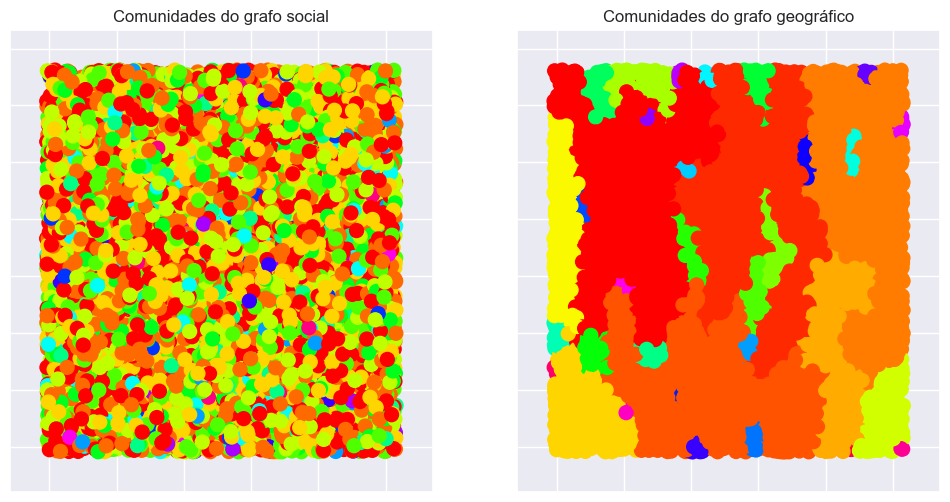

In [26]:
plot_colored_communities(grafo_erdos, grafo_geo_erdos, comunidade_social_erdos, comunidade_geo_erdos, with_labels=False)

In [27]:
jaccard_matrix_erdos = np.zeros((len(comunidade_social_erdos), len(comunidade_geo_erdos)))

for i, com_social in enumerate(comunidade_social_erdos):
    for j, com_geo in enumerate(comunidade_geo_erdos):
        jaccard_matrix_erdos[i][j] = jaccard_similarity(set(com_social), set(com_geo))

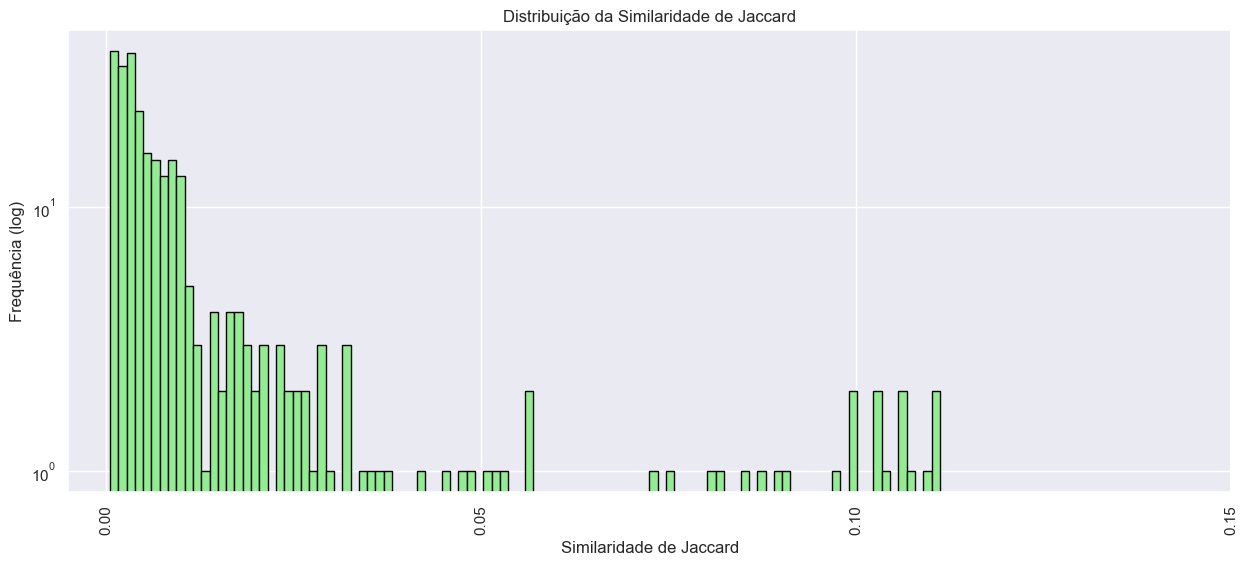

In [28]:
jaccard_values_erdos = jaccard_matrix_erdos[jaccard_matrix_erdos !=0]

plt.figure(figsize=(15, 6))
plt.hist(jaccard_values_erdos, bins=100, color='lightgreen', edgecolor='black', log=True)
plt.xlabel("Similaridade de Jaccard")
plt.xticks(np.arange(0, 0.2, 0.05), rotation=90)
plt.ylabel('Frequência (log)')
plt.title('Distribuição da Similaridade de Jaccard')
plt.show()

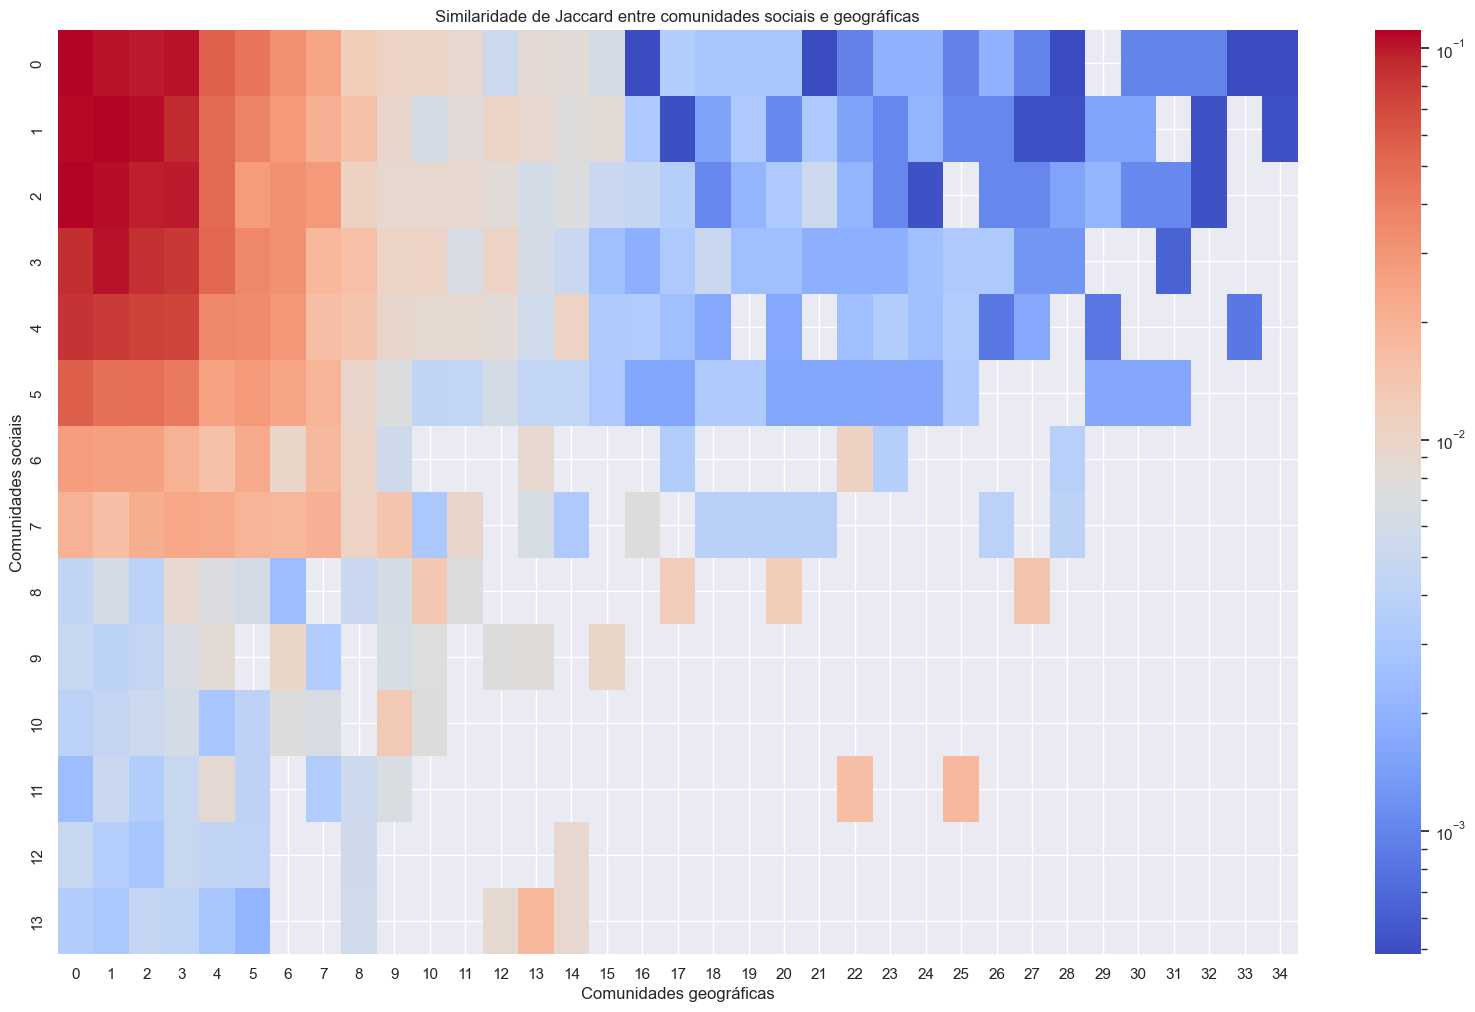

In [29]:
plt.figure(figsize=(20, 12))
sns.heatmap(jaccard_matrix_erdos, cmap='coolwarm', norm=LogNorm())
plt.xlabel('Comunidades geográficas')
plt.ylabel('Comunidades sociais')
plt.title('Similaridade de Jaccard entre comunidades sociais e geográficas')
plt.show()

In [30]:
ami_jaccard_erdos = ami(assign_labels(comunidade_social_erdos, grafo_erdos.nodes()), assign_labels(comunidade_geo_erdos, grafo_geo_erdos.nodes()))
print(f"AMI: {ami_jaccard_erdos}")

AMI: -0.0002630934315337413


#### Exportação

In [31]:
_export_graphml(grafo_erdos, 'E://', 'grafo_erdos.graphml')

### Modelo Watts–Strogatz

In [28]:
grafo_watts = nx.watts_strogatz_graph(NUMBER_OF_VERTICES, 10, 0.1)

In [29]:
show_graph_metrics(grafo_watts)

Nº de nós: 10000
Nº de links: 50000
Grau médio: 10.0
Densidade: 0.001000100010001


In [30]:
latitudes = np.random.uniform(LAT_MIN, LAT_MAX, NUMBER_OF_VERTICES)
longitudes = np.random.uniform(LON_MIN, LON_MAX, NUMBER_OF_VERTICES)

for i, node in enumerate(grafo_watts.nodes()):
    grafo_watts.nodes[node]['lat'] = latitudes[i]
    grafo_watts.nodes[node]['long'] = longitudes[i]
    
for node in list(grafo_watts.nodes())[:5]:
    print(f"Node: {node} - Lat: {grafo_watts.nodes[node]['lat']} - Long: {grafo_watts.nodes[node]['long']}")

Node: 0 - Lat: 41.76642303473276 - Long: -6.930810461400492
Node: 1 - Lat: 38.13983371347406 - Long: -7.455289309585059
Node: 2 - Lat: 39.716669226126136 - Long: -6.390546605234507
Node: 3 - Lat: 41.61050876958434 - Long: -8.534846206630565
Node: 4 - Lat: 37.42012531331787 - Long: -7.646594960032107


#### Criação do grafo geográfico

In [31]:
grafo_watts = convert_geo_to_utm(grafo_watts, 'lat', 'long')

In [32]:
for node in grafo_watts.nodes():
    lat = grafo_watts.nodes[node]['median_Y']
    long = grafo_watts.nodes[node]['median_X']
    grafo_watts.nodes[node]['coords'] = (lat, long)
    
for node in list(grafo_watts.nodes())[:5]:
    print(f"Node: {node} - Coords: {grafo_watts.nodes[node]['coords']}")

Node: 0 - Coords: (4625912.160261361, 671994.896963561)
Node: 1 - Coords: (4222457.148574933, 635367.4748559534)
Node: 2 - Coords: (4399566.963006867, 723674.36403303)
Node: 3 - Coords: (4606637.405545662, 538757.0044074632)
Node: 4 - Coords: (4142339.4647485595, 619757.8230420938)


In [49]:
geosocial_watts = ga.GeoSocial(grafo_watts, lat='lat', lon='long')

grafo_geo_watts = geosocial_watts.return_geographic_graph_by_radius(3500)

show_graph_metrics(grafo_geo_watts)

Nº de nós: 10000
Nº de links: 11560
Grau médio: 2.312
Densidade: 0.00023122312231223122


In [50]:
print(f"Componentes conexas: {nx.number_connected_components(grafo_geo_watts)}")

Componentes conexas: 2546


#### Criação das comunidades

In [38]:
comunidade_social_watts = nx.community.greedy_modularity_communities(grafo_watts)
comunidade_geo_watts = nx.community.greedy_modularity_communities(grafo_geo_watts)

In [39]:
node_community_map_social_watts = map_community_nodes(comunidade_social_watts)
node_community_map_geo_watts = map_community_nodes(comunidade_geo_watts)

for node in tqdmBasic(grafo_watts.nodes()):
    grafo_watts.nodes[node]['social_community'] = node_community_map_social_watts[node]
    grafo_watts.nodes[node]['geo_community'] = node_community_map_geo_watts[node]

100%|██████████| 10000/10000 [00:00<00:00, 1250836.22it/s]


#### Plotagem

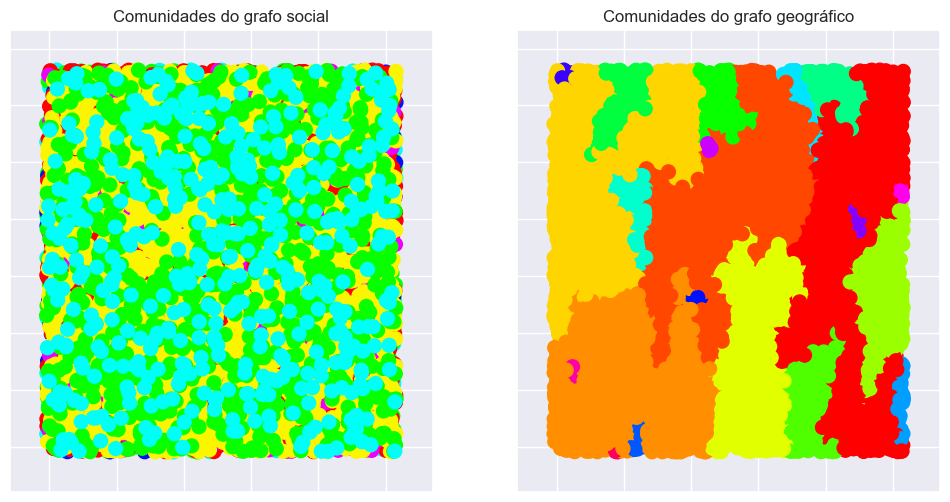

In [40]:
plot_colored_communities(grafo_watts, grafo_geo_watts, comunidade_social_watts, comunidade_geo_watts, with_labels=False)

In [41]:
jaccard_matrix_watts = np.zeros((len(comunidade_social_watts), len(comunidade_geo_watts)))

for i, com_social in enumerate(comunidade_social_watts):
    for j, com_geo in enumerate(comunidade_geo_watts):
        jaccard_matrix_watts[i][j] = jaccard_similarity(set(com_social), set(com_geo))

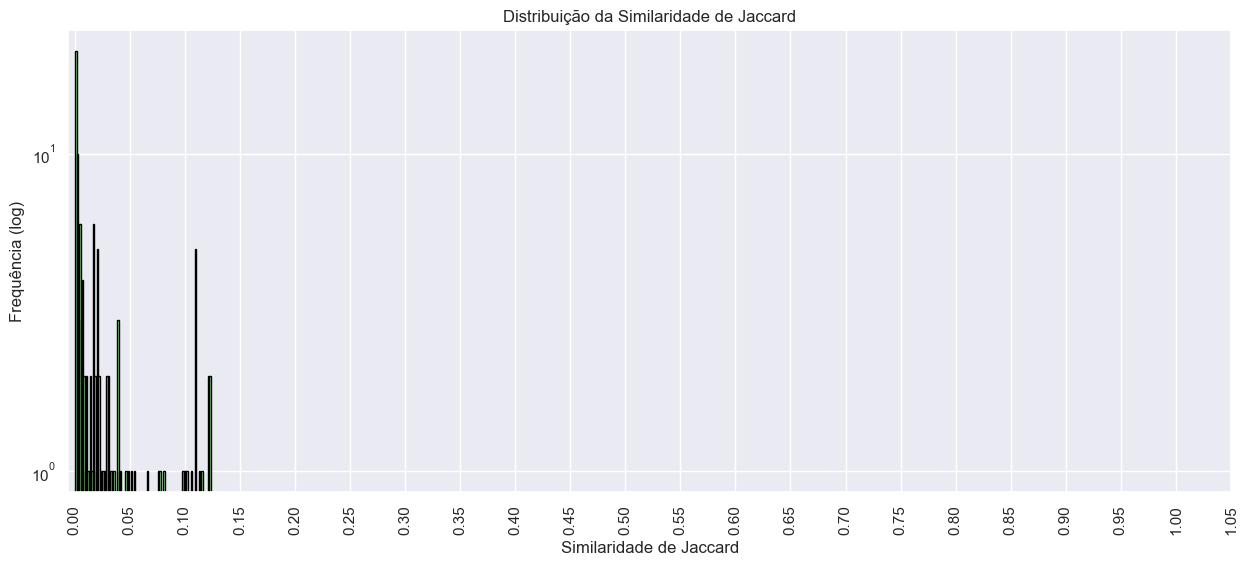

In [42]:
jaccard_values_watts = jaccard_matrix_watts[jaccard_matrix_watts !=0]

plt.figure(figsize=(15, 6))
plt.hist(jaccard_values_watts, bins=100, color='lightgreen', edgecolor='black', log=True)
plt.xlabel("Similaridade de Jaccard")
plt.xticks(np.arange(0, 1.1, 0.05), rotation=90)
plt.ylabel('Frequência (log)')
plt.title('Distribuição da Similaridade de Jaccard')
plt.show()

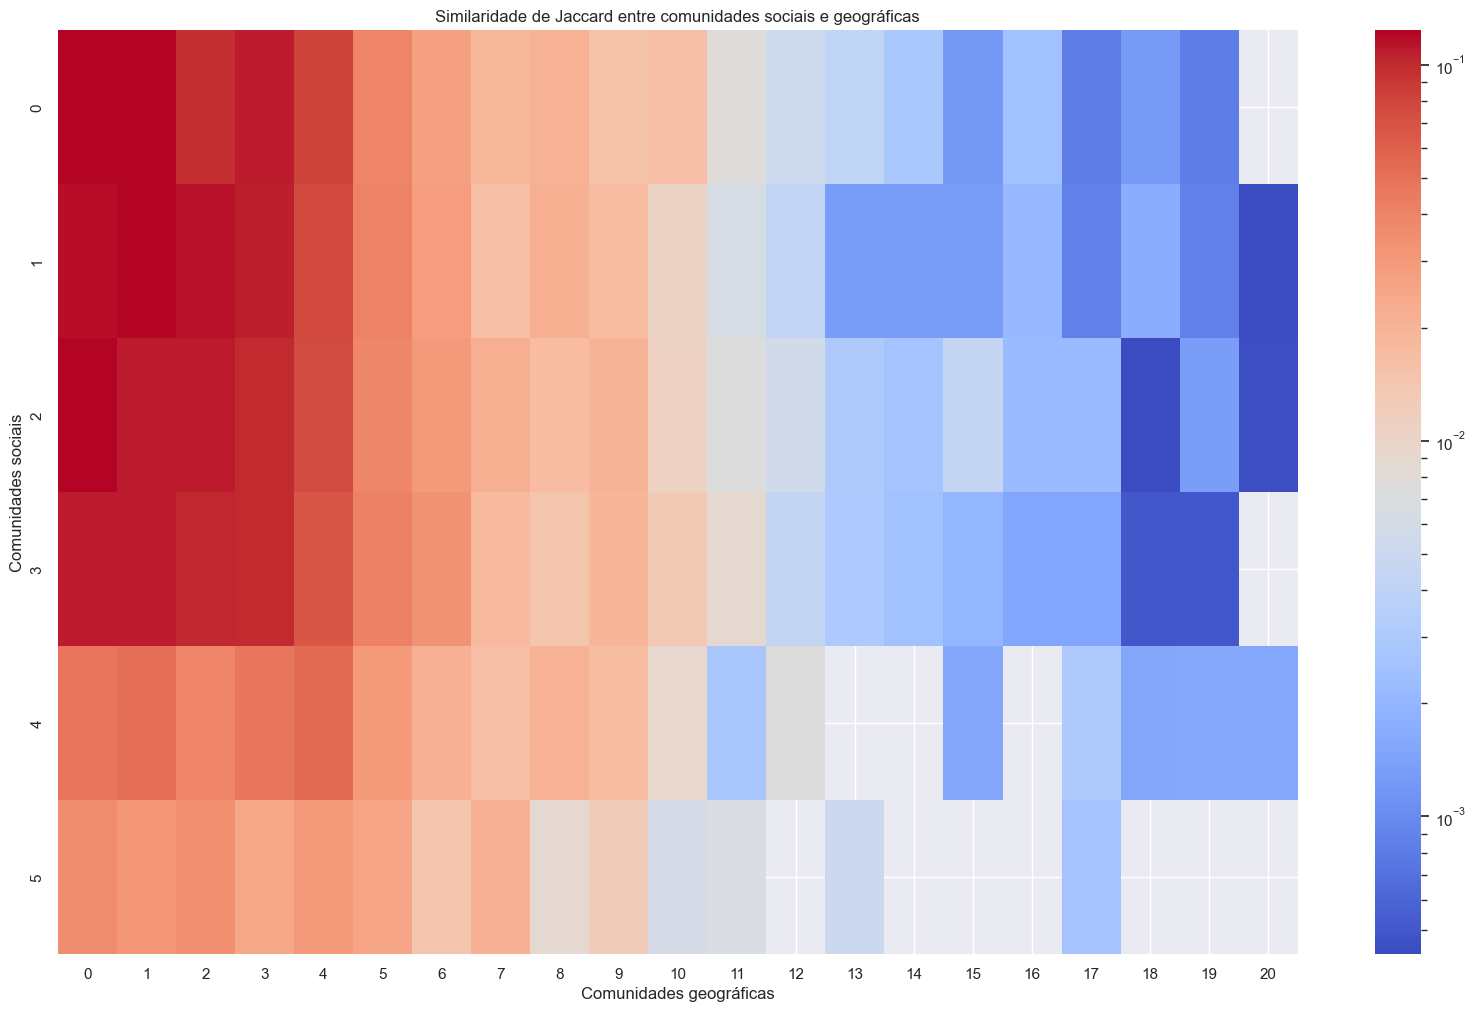

In [43]:
plt.figure(figsize=(20, 12))
sns.heatmap(jaccard_matrix_watts, cmap='coolwarm', norm=LogNorm())
plt.xlabel('Comunidades geográficas')
plt.ylabel('Comunidades sociais')
plt.title('Similaridade de Jaccard entre comunidades sociais e geográficas')
plt.show()

In [44]:
ami_jaccard_watts = ami(assign_labels(comunidade_social_watts, grafo_watts.nodes()), assign_labels(comunidade_geo_watts, grafo_geo_watts.nodes()))
print(f"AMI: {ami_jaccard_watts}")

AMI: -0.00029733419255462086


#### Exportação

In [62]:
_export_graphml(grafo_watts, 'E://', 'grafo_watts.graphml')

## Modelos que consideram a componente geográfica intrinsicamente

### Modelo de Waxman

In [35]:
grafo_waxman = nx.waxman_graph(NUMBER_OF_VERTICES, 0.04, 0.05, domain=(LAT_MIN, LAT_MAX, LON_MIN, LON_MAX))

In [36]:
show_graph_metrics(grafo_waxman)

Nº de nós: 10000
Nº de links: 51408
Grau médio: 10.2816
Densidade: 0.0010282628262826283


In [37]:
latitudes = np.random.uniform(LAT_MIN, LAT_MAX, NUMBER_OF_VERTICES)
longitudes = np.random.uniform(LON_MIN, LON_MAX, NUMBER_OF_VERTICES)

for i, node in enumerate(grafo_waxman.nodes()):
    grafo_waxman.nodes[node]['lat'] = latitudes[i]
    grafo_waxman.nodes[node]['long'] = longitudes[i]
    
for node in list(grafo_waxman.nodes())[:5]:
    print(f"Node: {node} - Lat: {grafo_waxman.nodes[node]['lat']} - Long: {grafo_waxman.nodes[node]['long']}")

Node: 0 - Lat: 41.73816352207795 - Long: -9.39717997310209
Node: 1 - Lat: 41.154797747317204 - Long: -8.072564423605078
Node: 2 - Lat: 37.468159167538886 - Long: -8.132995095866814
Node: 3 - Lat: 40.454893712017046 - Long: -8.463474617053876
Node: 4 - Lat: 40.95224406396256 - Long: -6.639081153319461


#### Criação do grafo geográfico

In [38]:
grafo_waxman = convert_geo_to_utm(grafo_waxman, 'lat', 'long')

In [39]:
for node in grafo_waxman.nodes():
    lat = grafo_waxman.nodes[node]['median_Y']
    long = grafo_waxman.nodes[node]['median_X']
    grafo_waxman.nodes[node]['coords'] = (lat, long)
    
for node in list(grafo_waxman.nodes())[:5]:
    print(f"Node: {node} - Coords: {grafo_waxman.nodes[node]['coords']}")

Node: 0 - Coords: (4620781.696938796, 466971.9674471186)
Node: 1 - Coords: (4556355.799948998, 577816.4424032465)
Node: 2 - Coords: (4147161.7309126984, 576667.9247554524)
Node: 3 - Coords: (4478386.166956855, 545492.4060285563)
Node: 4 - Coords: (4536139.847608185, 698708.1635610104)


In [53]:
geosocial_waxman = ga.GeoSocial(grafo_waxman, lat='lat', lon='long')

grafo_geo_waxman = geosocial_waxman.return_geographic_graph_by_radius(3500)

show_graph_metrics(grafo_geo_waxman)

Nº de nós: 10000
Nº de links: 11512
Grau médio: 2.3024
Densidade: 0.00023026302630263027


In [54]:
print(f"Componentes conexas: {nx.number_connected_components(grafo_geo_waxman)}")

Componentes conexas: 2545


#### Criação das comunidades

In [69]:
comunidade_social_waxman = nx.community.greedy_modularity_communities(grafo_waxman)
comunidade_geo_waxman = nx.community.greedy_modularity_communities(grafo_geo_waxman)

In [70]:
node_community_map_social_waxman = map_community_nodes(comunidade_social_waxman)
node_community_map_geo_waxman = map_community_nodes(comunidade_geo_waxman)

for node in tqdmBasic(grafo_waxman.nodes()):
    grafo_waxman.nodes[node]['social_community'] = node_community_map_social_waxman[node]
    grafo_waxman.nodes[node]['geo_community'] = node_community_map_geo_waxman[node]

100%|██████████| 10000/10000 [00:00<00:00, 1428529.00it/s]


#### Plotagem

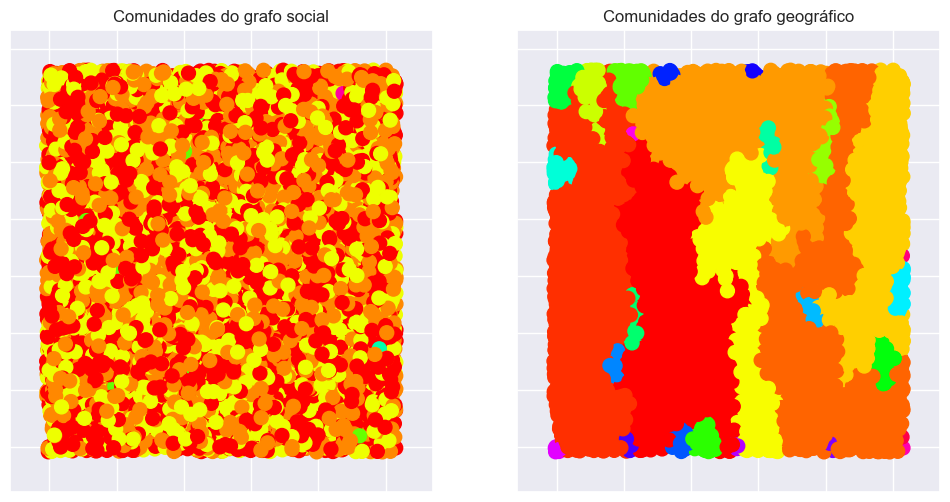

In [71]:
plot_colored_communities(grafo_waxman, grafo_geo_waxman, comunidade_social_waxman, comunidade_geo_waxman, with_labels=False)

In [72]:
jaccard_matrix_waxman = np.zeros((len(comunidade_social_waxman), len(comunidade_geo_waxman)))

for i, com_social in enumerate(comunidade_social_waxman):
    for j, com_geo in enumerate(comunidade_geo_waxman):
        jaccard_matrix_waxman[i][j] = jaccard_similarity(set(com_social), set(com_geo))

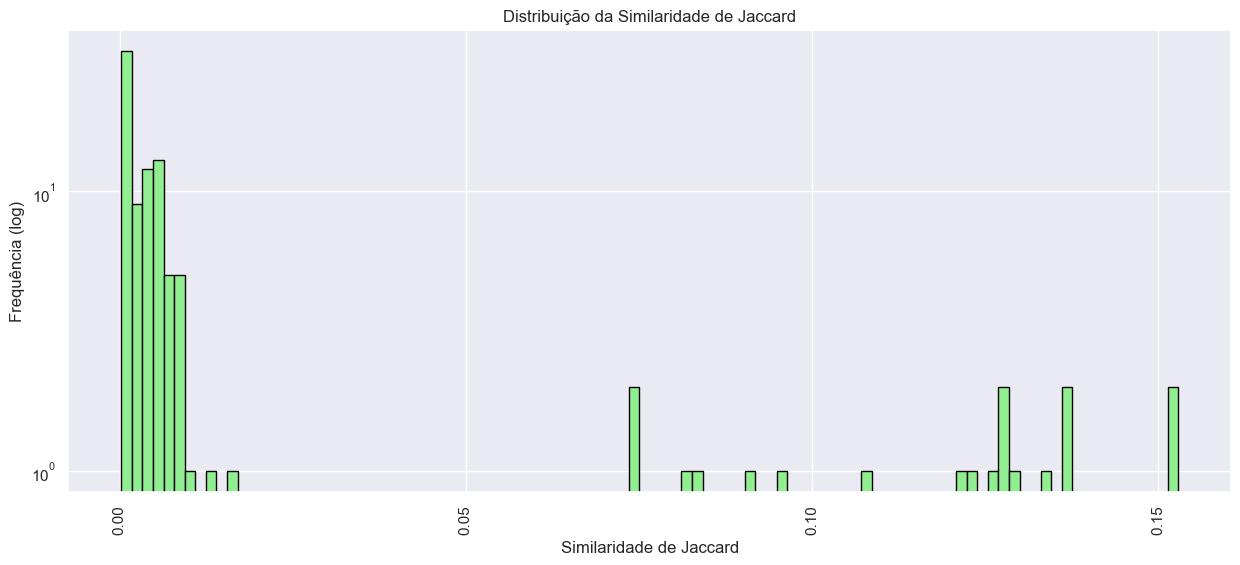

In [73]:
jaccard_values_waxman = jaccard_matrix_waxman[jaccard_matrix_waxman !=0]

plt.figure(figsize=(15, 6))
plt.hist(jaccard_values_waxman, bins=100, color='lightgreen', edgecolor='black', log=True)
plt.xlabel("Similaridade de Jaccard")
plt.xticks(np.arange(0, 0.2, 0.05), rotation=90)
plt.ylabel('Frequência (log)')
plt.title('Distribuição da Similaridade de Jaccard')
plt.show()

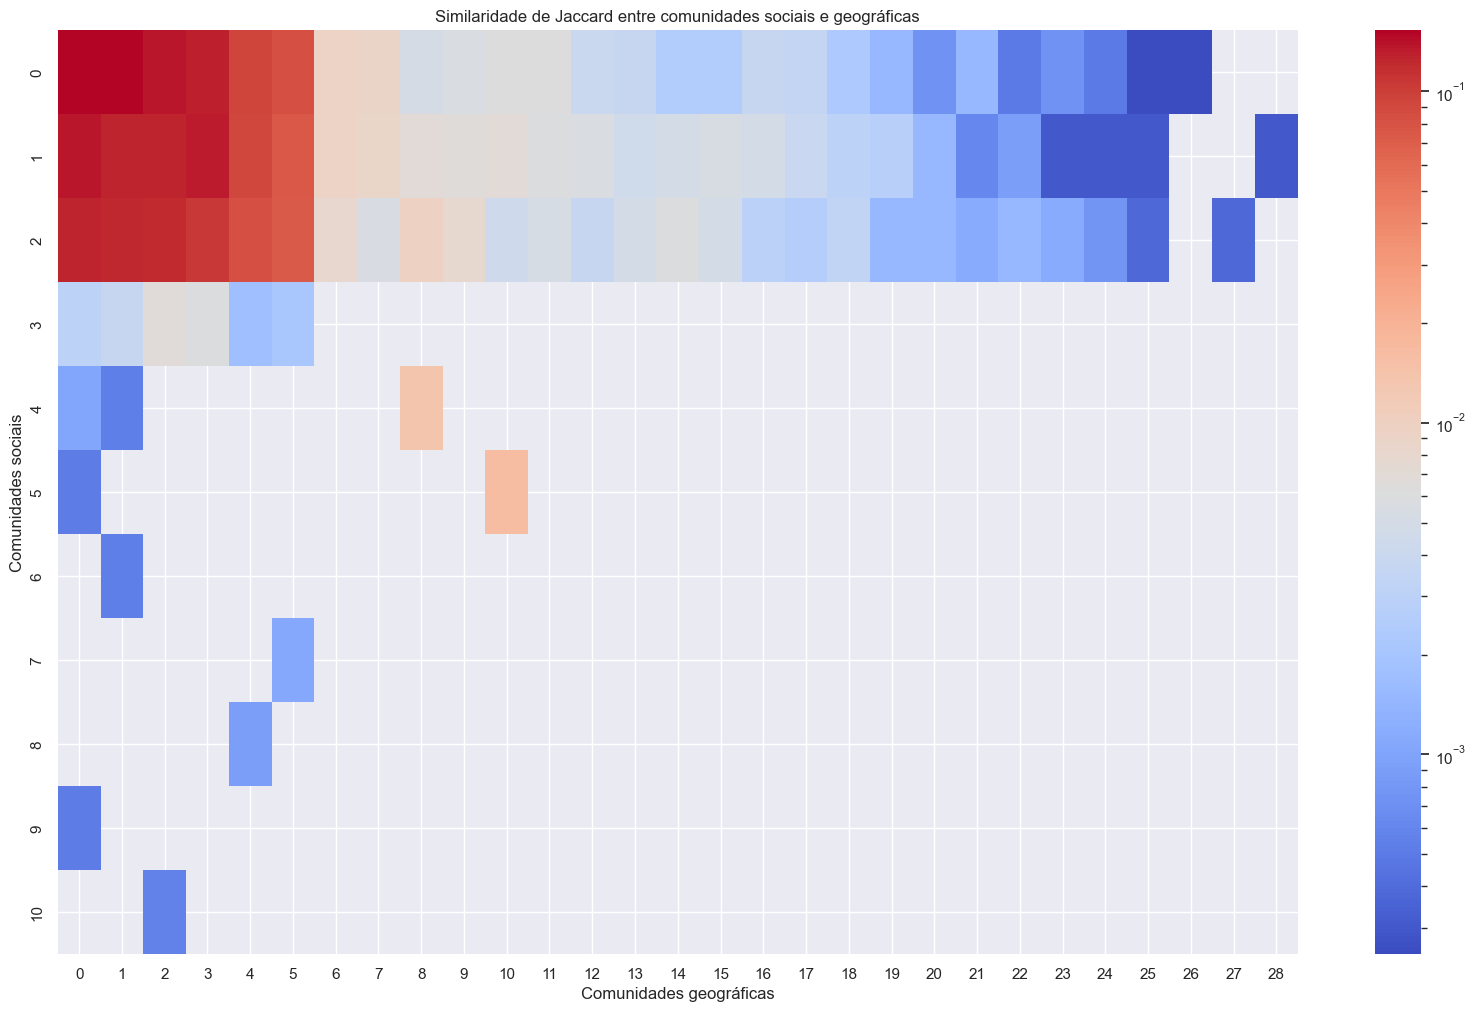

In [74]:
plt.figure(figsize=(20, 12))
sns.heatmap(jaccard_matrix_waxman, cmap='coolwarm', norm=LogNorm())
plt.xlabel('Comunidades geográficas')
plt.ylabel('Comunidades sociais')
plt.title('Similaridade de Jaccard entre comunidades sociais e geográficas')
plt.show()

In [75]:
ami_waxman = ami(assign_labels(comunidade_social_waxman, grafo_waxman.nodes()), assign_labels(comunidade_geo_waxman, grafo_geo_waxman.nodes()))
print(f"AMI: {ami_waxman}")

AMI: -0.0001595059148980741


#### Exportação

In [82]:
_export_graphml(grafo_waxman, 'E://', 'grafo_waxman.graphml')

# Fim